In [2]:
import asyncio
import time
import json
import os
import re

from agent_prompts import customer_sys_prompt, support_agent_sys_prompt
from autogen import ConversableAgent
from dotenv import load_dotenv
from itertools import islice

load_dotenv()

ModuleNotFoundError: No module named 'agent_prompts'

In [22]:
llm_config = {
    "config_list": [
        {
            "model": "gpt-4o-mini",
            "api_key": os.getenv("OPENAI_API_KEY"),
            "price": [0.000150, 0.000600],
            "cache_seed": None,
        }
    ]
}

In [3]:
def create_agent(
    name: str,
    sys_prompt: str,
    human_input_mode: str,
    termination_msg: str | None = None,
):
    return ConversableAgent(
        name=name,
        system_message=sys_prompt,
        is_termination_msg=lambda msg: termination_msg in msg["content"]
        if termination_msg
        else None,
        human_input_mode=human_input_mode,
        llm_config=llm_config,
        silent=True
    )

In [4]:
def process_queries(queries: dict[str, str | list[str]]):
    guidelines = queries["guidelines"]
    f = open("convo.txt", "a")
    for i, query in enumerate(queries["customer_queries"]):
        if i == 3:
            break
        customer_agent = create_agent(
            "Customer",
            customer_sys_prompt.format(guidelines=guidelines),
            "NEVER",
            "RESOLVED",
        )
        support_agent = create_agent(
            "Support_Agent", support_agent_sys_prompt, "NEVER", "RESOLVED"
        )
        chat_result = customer_agent.initiate_chat(support_agent, message=query)
    f.close()


In [5]:
# with open("../query_gen/queries.jsonl", "r") as f:
#     for line in f:
#         queries = json.loads(line)
#         process_queries(queries)
#         break

In [47]:
async def process_batch(queries: list[str], out_file, guidelines: str):
    """Processes a batch of queries."""
    for j, query in enumerate(queries["customer_queries"]):
        customer_agent = create_agent(
            "Customer",
            customer_sys_prompt.format(guidelines=guidelines),
            "NEVER",
            "RESOLVED",
        )
        support_agent = create_agent(
            "Support_Agent", support_agent_sys_prompt, "NEVER", "RESOLVED"
        )

        # remove number at the start if present
        query = re.sub(r"^\d+\.\s*", "", query)
        chat_result = await customer_agent.a_initiate_chat(support_agent, message=query)
        out_json = {
            "title": queries["title"], 
            "tone": queries["tone"],
            "style": queries["style"],
            "conversation": chat_result.chat_history,
            "length": len(chat_result.chat_history),
            "status": "UNRESOLVED" if "UNRESOLVED" in chat_result.chat_history[-1]["content"]\
                      else "RESOLVED"
        }
        json.dump(out_json, out_file, ensure_ascii=False)
        out_file.write("\n")

In [48]:
async def process_query_file(inp_file_str: str, out_file_str: str, batch_sz: int = 3):
    inp_file = open(inp_file_str, 'r')
    out_file = open(out_file_str, 'r')

    i = 1
    while True:
        query_set = list(islice(inp_file, batch_sz))
        if not batch:
            print(f"Finished generation for file: {inp_file_str}")
            break

        print(f"Processing query_set {i}.")
        tasks = [
            process_batch(
                queries=json.loads(queries)["customer_queries"],
                out_file=out_file,
                guidelines=open(f"/home/suchitg/amazon_help/leafdirs/{queries["title"]}/t.txt", "r").read()
            )
            for queries in query_set
        ]
        await asyncio.gather(*tasks)
        i += 1

In [16]:
def process_query_file(inp_file_str: str, out_file_str: str, batch_sz: int = 3):
    inp_file = open(inp_file_str, 'r')
    out_file = open(out_file_str, 'r')

    
    for i, line in enumerate(inp_file):
        queries = json.loads(line)
        guidelines = open(f"/home/suchitg/amazon_help/leafdirs/{queries['title']}/t.txt", "r").read()
        for j, query in enumerate(queries["customer_queries"]):
            customer_agent = create_agent(
                "Customer",
                customer_sys_prompt.format(guidelines=guidelines),
                "NEVER",
                "RESOLVED",
            )
            support_agent = create_agent(
                "Support_Agent", support_agent_sys_prompt, "NEVER", "RESOLVED"
            )
            query = re.sub(r"^\d+\.\s*", "", query)
            chat_result = await customer_agent.a_initiate_chat(support_agent, message=query)
            out_json = {
                "title": queries["title"], 
                "tone": queries["tone"],
                "style": queries["style"],
                "conversation": chat_result.chat_history,
                "length": len(chat_result.chat_history),
                "status": "UNRESOLVED" if "UNRESOLVED" in chat_result.chat_history[-1]["content"]\
                          else "RESOLVED"
            }
            json.dump(out_json, out_file, ensure_ascii=False)
            out_file.write("\n")
            # open("./convo.jsonl", 'a').write('\n')
        break
        #     if j == 5:
        #         break
        # if i == 2:
        #     break
    
    inp_file.close()
    out_file.close()

[autogen.oai.client: 11-18 12:25:20] {184} WARNING - The API key specified is not a valid OpenAI format; it won't work with the OpenAI-hosted model.
[autogen.oai.client: 11-18 12:25:21] {184} WARNING - The API key specified is not a valid OpenAI format; it won't work with the OpenAI-hosted model.
[autogen.oai.client: 11-18 12:25:24] {184} WARNING - The API key specified is not a valid OpenAI format; it won't work with the OpenAI-hosted model.
[autogen.oai.client: 11-18 12:25:24] {184} WARNING - The API key specified is not a valid OpenAI format; it won't work with the OpenAI-hosted model.
[autogen.oai.client: 11-18 12:25:28] {184} WARNING - The API key specified is not a valid OpenAI format; it won't work with the OpenAI-hosted model.
[autogen.oai.client: 11-18 12:25:28] {184} WARNING - The API key specified is not a valid OpenAI format; it won't work with the OpenAI-hosted model.
[autogen.oai.client: 11-18 12:25:31] {184} WARNING - The API key specified is not a valid OpenAI format; i

- send file to main function for processing
- each file has many _batches_ of queries
    - each batch has a bunch of customer queries
- process 1 file at a time
- the "bunch" of queries in each batch can be processed asynchronously by autogen native async functionality
- TODO: process batches in parallel

In [17]:
print(end - start)

49.39613747596741


In [1]:
import json

In [17]:
r, u = 0, 0
convo_len = 0
length = 0
len_stats = []
i = 0
err = 0
for line in open("../conversation_data/non_native_convos.jsonl", 'r'):
    l = json.loads(line)
    if l['length'] > 50:
        print("oo: ", l['length'])
    len_stats.append(l['length'])
    convo_len += l['length']
    length += 1
    i += 1
        
    if l["status"] == "RESOLVED":
        r += 1
    else:
        u += 1

    if l['status'] == "ERROR":
        err += 1
        print("EE: ", l)
        

    if l['length'] > 20:
        temp =  l['conversation']

EE:  {'title': 'ShipppingSpeedAndCharges', 'tone': 'neutral', 'style': 'non_native', 'conversation': [], 'length': 0, 'status': 'ERROR', 'error': "Error code: 500 - {'error': {'message': 'The model produced invalid content. Consider modifying your prompt if you are seeing this error persistently.', 'type': 'model_error', 'param': None, 'code': None}}"}
oo:  101
oo:  101
EE:  {'title': 'UnkownCharges', 'tone': 'annoyed', 'style': 'non_native', 'conversation': [], 'length': 0, 'status': 'ERROR', 'error': "Error code: 500 - {'error': {'message': 'The model produced invalid content. Consider modifying your prompt if you are seeing this error persistently.', 'type': 'model_error', 'param': None, 'code': None}}"}
EE:  {'title': 'PriceMatching', 'tone': 'annoyed', 'style': 'non_native', 'conversation': [], 'length': 0, 'status': 'ERROR', 'error': "Error code: 500 - {'error': {'message': 'The model produced invalid content. Consider modifying your prompt if you are seeing this error persistent

In [19]:
r, u

(2583, 1316)

In [11]:
convo_len / length

8.094126699153628

In [12]:
min(len_stats), max(len_stats)

(0, 23)

In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
np.median(len_stats)

7.0

(array([6.000e+00, 2.000e+00, 4.980e+02, 2.732e+03, 4.560e+02, 1.430e+02,
        4.300e+01, 1.500e+01, 3.000e+00, 1.000e+00]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <BarContainer object of 10 artists>)

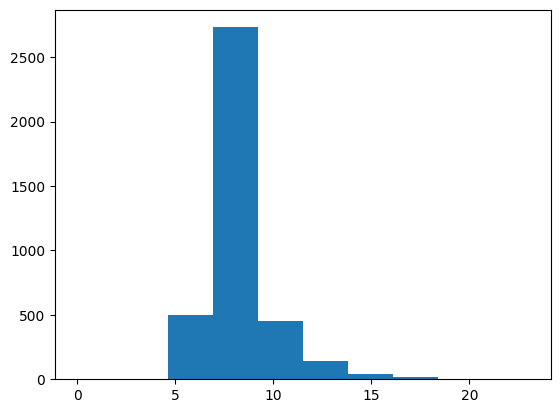

In [15]:
plt.hist(len_stats)

TODO:
- identify and remove convos with super-long lengths
- look into errors